### Import python libraries and local functions. 

In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import *
from ToolBox import IV_style
from scipy.optimize import leastsq
%matplotlib widget

### Define your path to your data
#### The glob function helps you filter your files

In [3]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Good/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Good/20240617_LTP',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240614_Slice_evoked',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240612_Slice_day_1',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240607_K+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240610_Ca+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/juliana - striatum',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240611_SingleChannel']

In [4]:
files = glob(folders[3]+"/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/cell001_Na_IV_curve.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0002.abf']

In [5]:
## List the protocol for each files
get_protocol(files)

['Na IV Curve',
 'Na IV Curve',
 'Steady State Inactivation',
 'Na IV Curve',
 'Recovery from Inactivation Na',
 'Na IV Curve',
 'Steady State Inactivation',
 'Na IV Curve']

# IV curve 
#### choose the list of files you want based on the protocol names:

In [7]:
iv_files = files_from_protocol('Na IV Curve',files)
iv_files

['/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/cell001_Na_IV_curve.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0002.abf']

#### Explore files

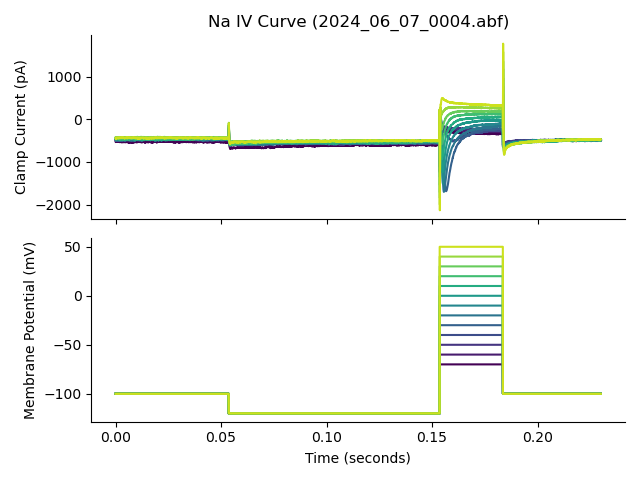

In [8]:
plt.close('all')
f = iv_files[1]
plot_swps(f)

### Select the file you want to analyse and extract raw data: 

In [9]:
f = iv_files[1]
## Extract the sweeps,time and sampling rate:
swps, swp_time, sr = get_sweeps(f)

### Extract the voltage steps from your membrane potential trace (channel 1).
#### From your recording, set the start and end time (in sec):

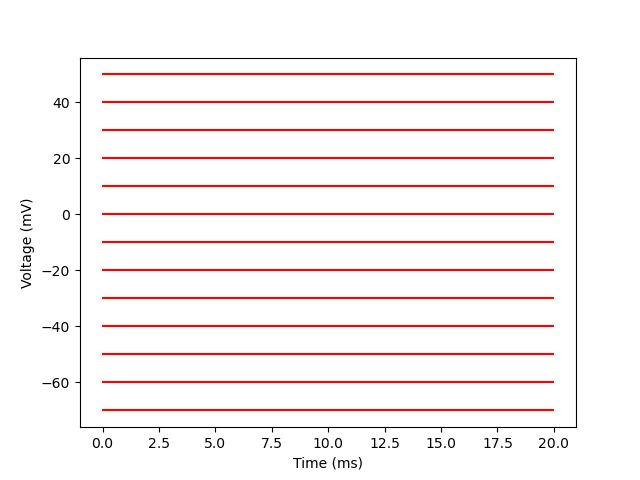

In [10]:
v_start = 0.160
v_end = 0.180
voltage_trace = swp_window(swps,v_start,v_end,sr,channel=1)
## lets see the chosen window:
fig,ax = plt.subplots()
t = np.arange(len(voltage_trace[0]))/sr
for v in voltage_trace:
    ax.plot(t*1e3,v,'red')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
plt.show()

### Then calculate the mean for each trace using numpy mean function:
### setting the rigth axis to calculate the mean is crucial.

In [11]:
voltage_step = np.mean(voltage_trace,axis=1)
voltage_step

array([-70., -60., -50., ...,  30.,  40.,  50.])

### The Baseline holding current (channel 0):

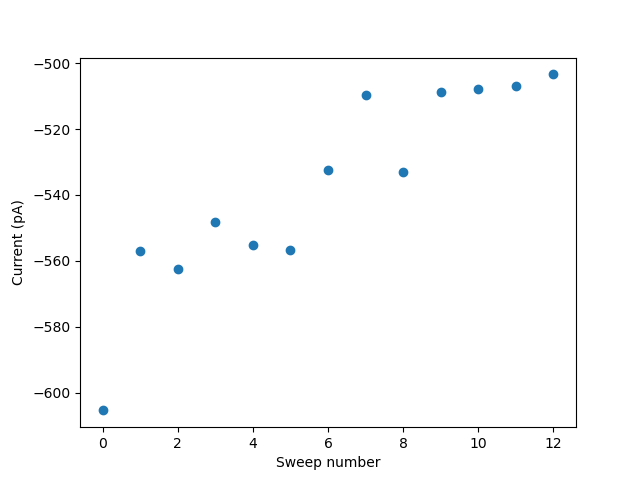

In [12]:
i_start = 0.1375
i_end = 0.1525
baseline_current = np.mean(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
# print(baseline_current)
fig,ax = plt.subplots()
ax.plot(baseline_current,'o')
ax.set_xlabel('Sweep number')
ax.set_ylabel('Current (pA)')
plt.show()

###  The peak response in your current (here Na)
#### To choose your window you need to have only the peak you are intereste in.
#### Getting rid of the capacitive transient is crucial !

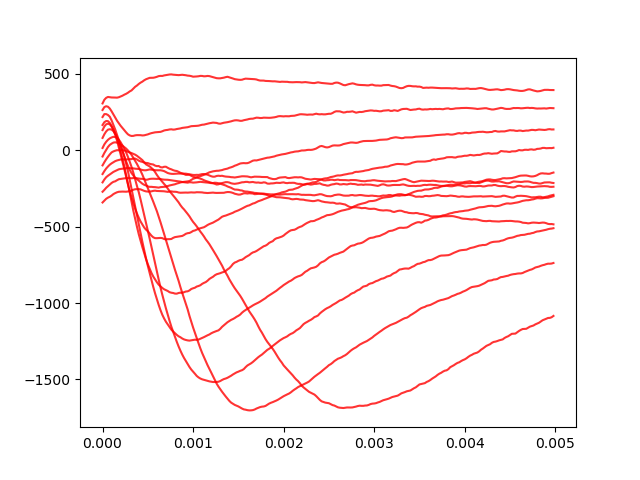

In [13]:
i_start = 0.154
i_end = 0.159
peak_window = swp_window(swps,i_start,i_end,sr,channel=0)
fig,ax = plt.subplots()
t = np.arange(len(peak_window[0]))/sr
for c in peak_window:
    ax.plot(t,c,'red',alpha=0.8)
plt.show()

### Extract the peak (positive or negative)
#### Break down to understand the process : 

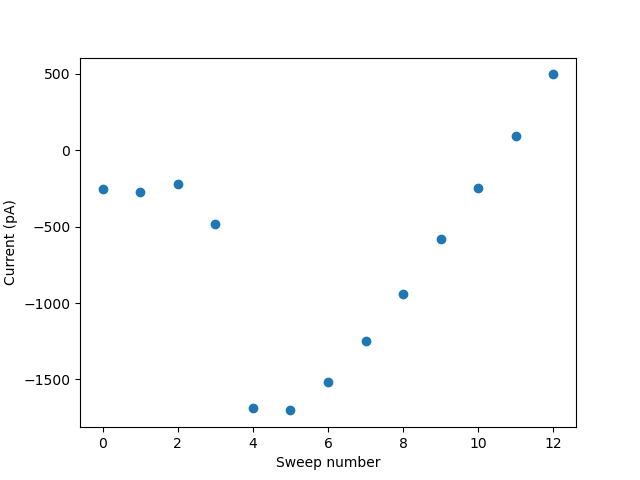

In [14]:
## initialise your list to store the amplitudes
peak_response = []
## loop for each trace
for swp in peak_window:
    ## normalise the trace on the 10 first points:
    base = np.mean(swp[0:10])
    norm = swp - base
    ## take the absolute trace:
    abs_trace =  abs(norm)
    ## get the position of the max response:
    i_peak = np.argmax(abs_trace)
    ## from the original swp get the 
    ## value at the absolute max position:
    peak = swp[i_peak]
    ## append to the storage list
    peak_response.append(peak)

fig,ax = plt.subplots()
ax.plot(peak_response,'o')
ax.set_xlabel('Sweep number')
ax.set_ylabel('Current (pA)')
plt.show()

### Fortunatly you can write this in one line with our beloved list comprehension,
### and to be even classier we can define a function

In [15]:
def peak(peak_window):
    return np.array([s[np.argmax(np.abs(s - np.mean(s[0:10])))] 
                     for s in peak_window])

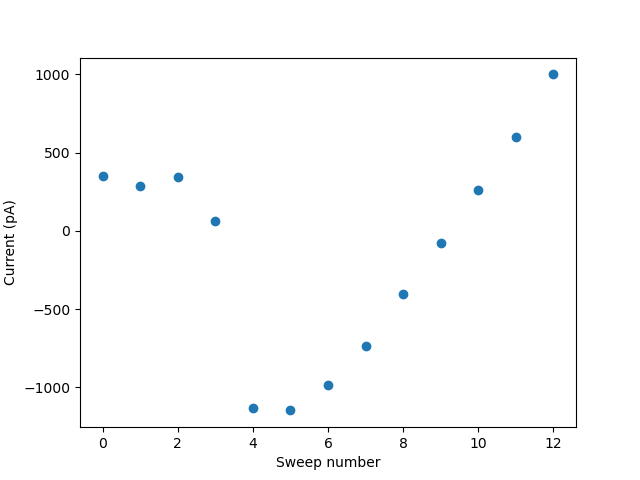

In [16]:
peak_response = peak(peak_window)
## and normalise over the baseline current:
peak_response -= baseline_current
fig,ax = plt.subplots()
ax.plot(peak_response,'o')
ax.set_xlabel('Sweep number')
ax.set_ylabel('Current (pA)')
plt.show()

### Lets put all this into a nice looking plot:

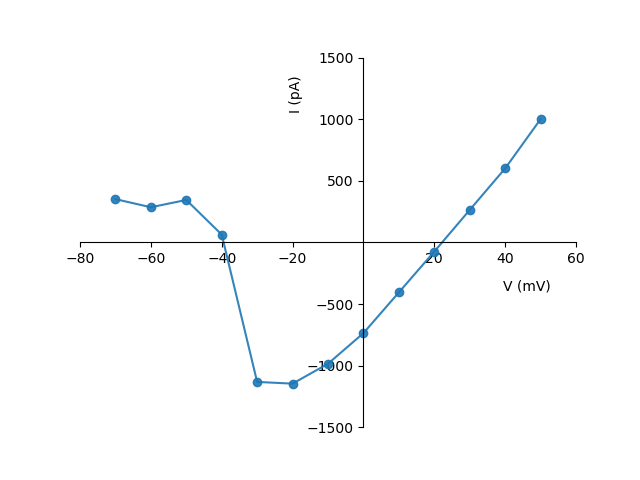

In [17]:
fig,ax = plt.subplots()
ax.plot(voltage_step,peak_response,'-o',alpha=0.9)
ax.set_xlabel('V (mV)')
ax.set_ylabel('I (pA)')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_label_coords(0.9, 0.4) 
ax.yaxis.set_label_coords(0.45, 0.9)
# Customize ticks to remove the 0 ticks and labels
xticks = [tick for tick in ax.get_xticks() if tick != 0]
yticks = [tick for tick in ax.get_yticks() if tick != 0]
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.show()

In [18]:
## create a function to add the style to a existing ax
def IV_style(ax,
            xcoord=(0.9, 0.4),
            ycoord=(0.45, 0.9)):
    '''
    ax from fig,ax = plt.subplots()
    xcoord and ycoord are coordinate for the axis labels
    '''
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.set_xlabel('V (mV)')
    ax.set_ylabel('I (pA)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_label_coords(xcoord[0], xcoord[1]) 
    ax.yaxis.set_label_coords(ycoord[0], ycoord[1])
    # Customize ticks to remove the 0 ticks and labels
    xticks = [tick for tick in ax.get_xticks() if tick != 0]
    yticks = [tick for tick in ax.get_yticks() if tick != 0]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

### Now lets put all this into a function !

In [19]:
def IV(f,vtimes,btimes,ptimes,plot=True,
       xcoord=(0.9, 0.4),ycoord=(0.45, 0.9)):
    '''
    Takes a filename : f
    ALL TIMES IN SECONDS
    voltage step window (vtimes): (v_start,v_end)
    baseline current window (btimes): (i_start,i_end)
    peak current window (ptimes): (i_start,i_end)
    plot : boolean to show or not the plot
    xcoord and ycoord are coordinate for the axis labels
    
    returns the peak amplitudes and voltage steps values.
    '''
    # Extract the sweeps,time and sampling rate:
    swps, swp_time, sr = get_sweeps(f)
    # Extract the start and end window times:
    v_start,v_end = vtimes
    b_start,b_end = btimes
    p_start,p_end = ptimes
    # extract the voltage steps:
    voltage_trace = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
    # extract baseline current:
    baseline_current = np.mean(swp_window(swps,b_start,b_end,sr,channel=0),axis=1)
    # extract peak current:
    peak_window = swp_window(swps,p_start,p_end,sr,channel=0)
    peak_response = peak(peak_window)
    # and normalise over the baseline current:
    peak_response -= baseline_current
    # plot the result:
    if plot==True:
        fig,ax = plt.subplots()
        ax.plot(voltage_step,peak_response,'-o',alpha=0.9)
        IV_style(ax,xcoord=xcoord,ycoord=ycoord)
        plt.show()
    
    return voltage_step,peak_response

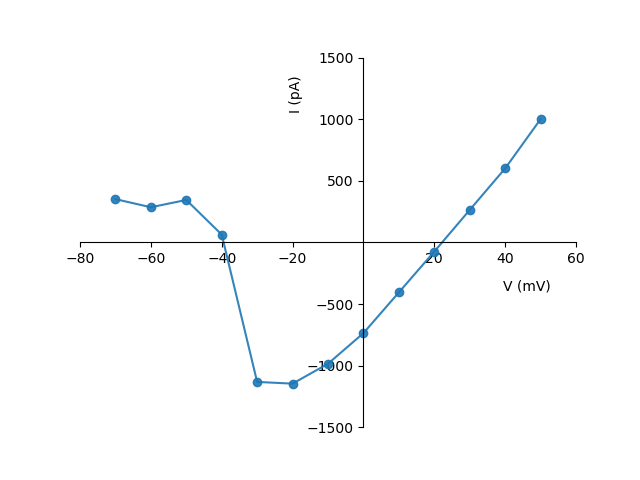

In [20]:
vtimes = (0.160,0.180)
btimes = (0.1375,0.1525)
ptimes = (0.154,0.159)
v,i = IV(f,vtimes,btimes,ptimes)

### Lets loop that around all the IV files:

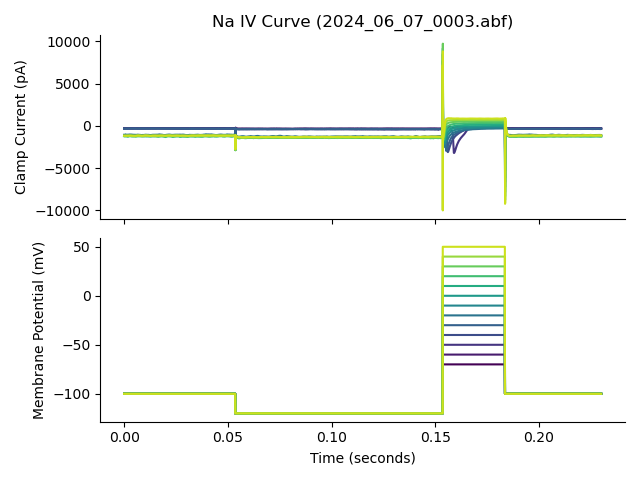

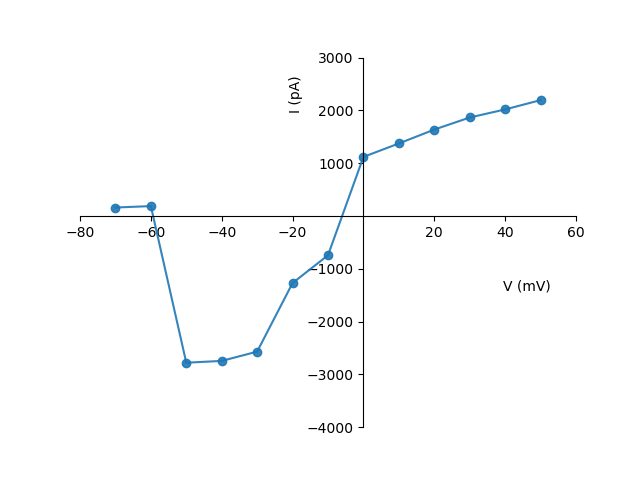

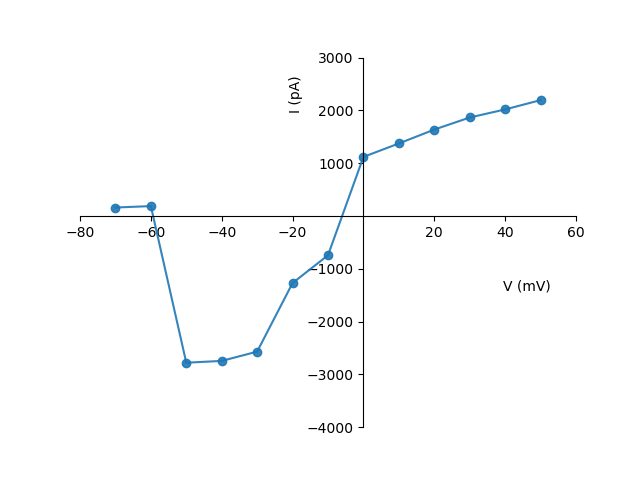

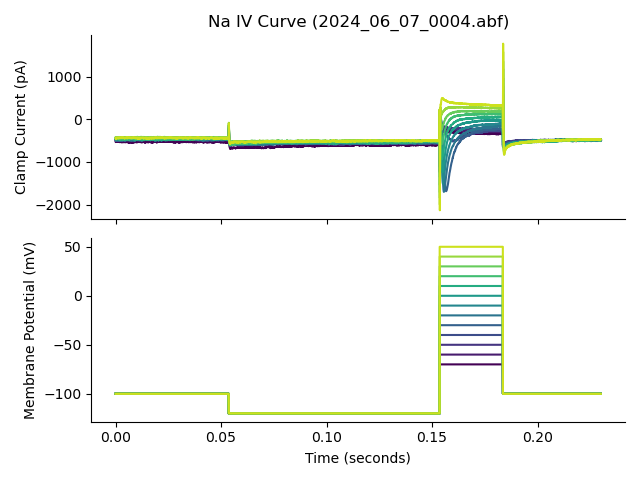

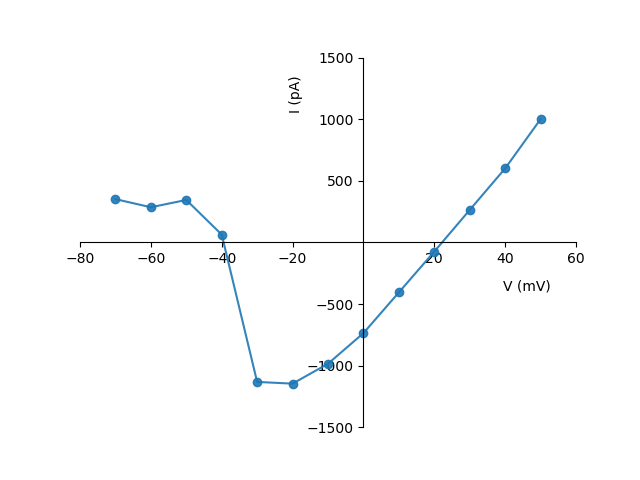

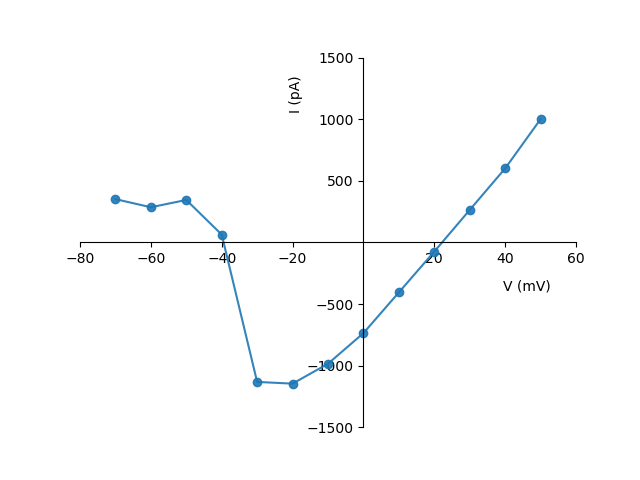

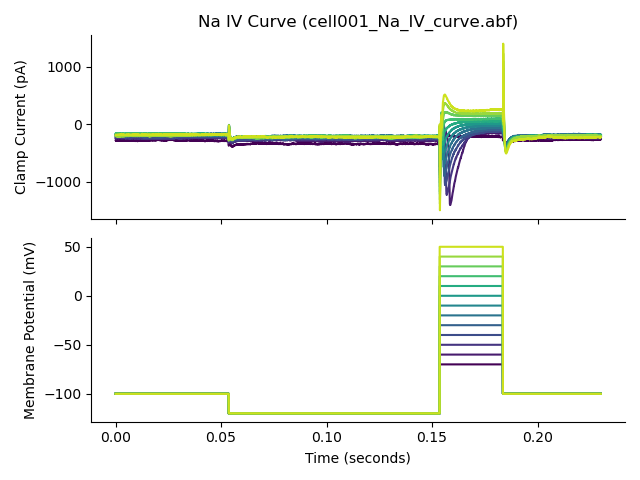

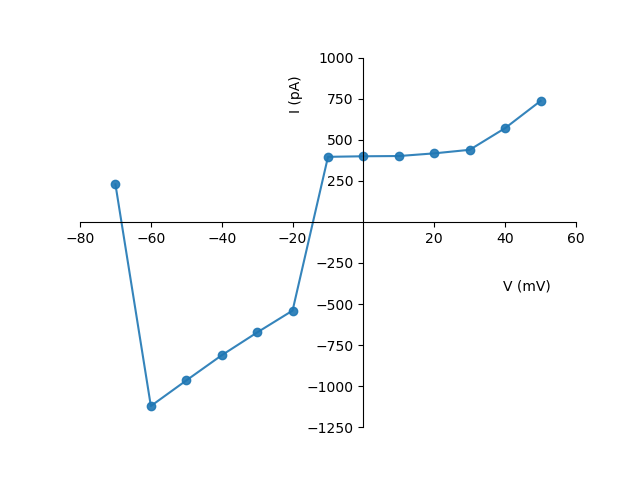

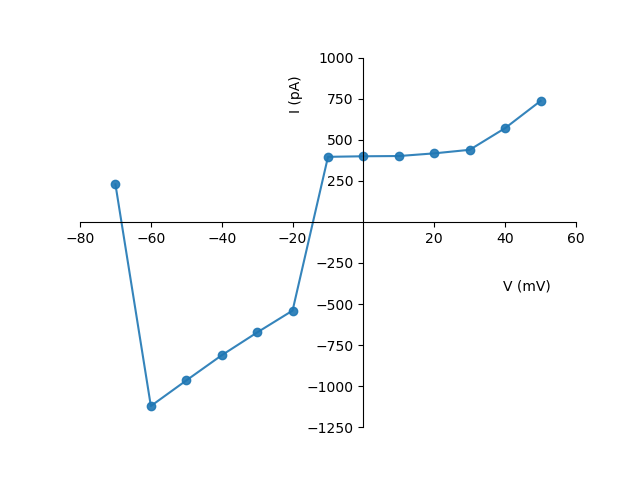

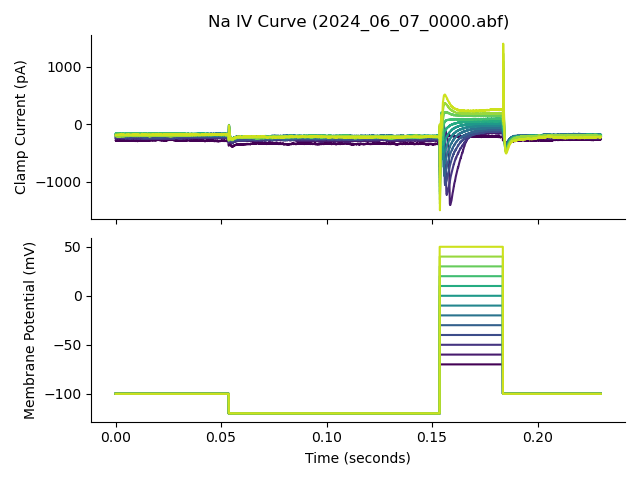

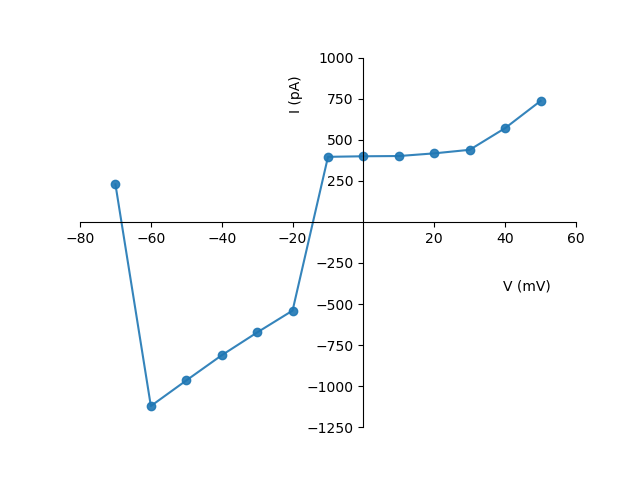

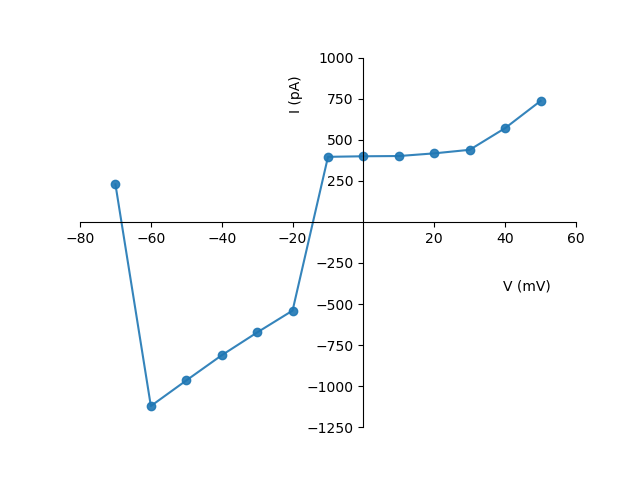

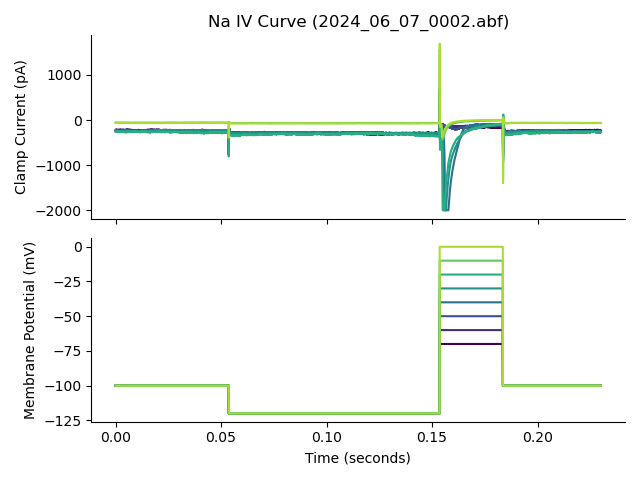

/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0002.abf
Error computing the IV curve 


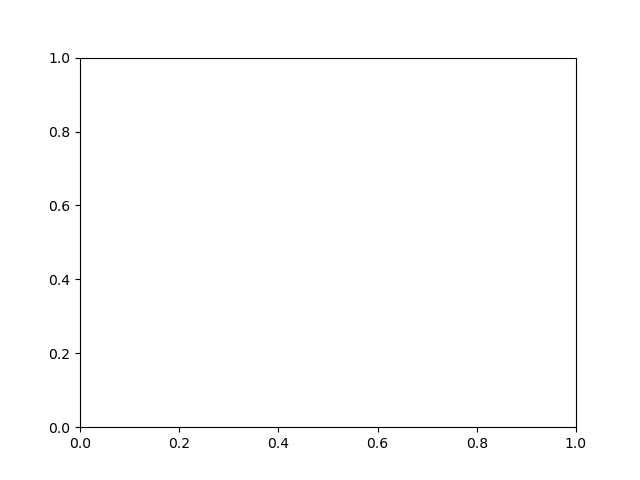

In [21]:
plt.close('all')
vtimes = (0.160,0.180)
btimes = (0.1375,0.1525)
ptimes = (0.154,0.159)
for f in iv_files:
    plot_swps(f)
    try:
        v,i = IV(f,vtimes,btimes,ptimes)
    except:
        print(f)
        print('Error computing the IV curve ')
    plt.show()

### Finally take all the IV curves into one plots 

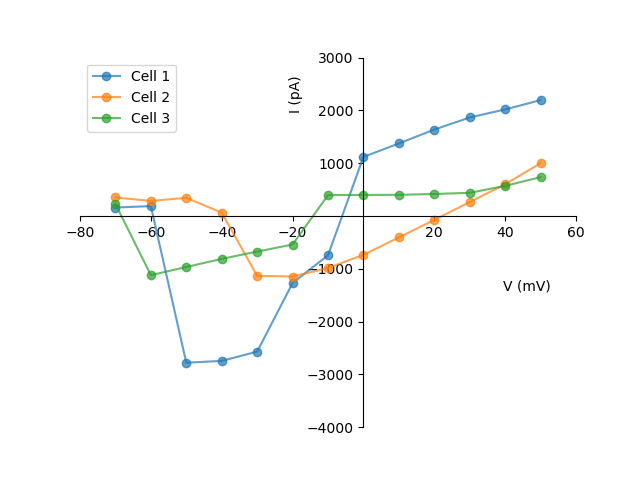

In [22]:
vtimes = (0.160,0.180)
btimes = (0.1375,0.1525)
ptimes = (0.154,0.159)
iv = []
fig,ax = plt.subplots()
for j,f in enumerate(iv_files[:-2]):
    v,i = IV(f,vtimes,btimes,ptimes,plot=False)
    ax.plot(v,i,'-o',alpha=0.7,label=f'Cell {j+1}')
    iv.append((i,v))
IV_style(ax)
ax.legend()
plt.show()

# All the function are in the ToolBox.py files and can be imported in your own notebooks

In [25]:
from ToolBox import * ## import all the function 
from ToolBox import IV ## only imports the IV function
import ToolBox as TB ## you call any function by calling TB.function (example TB.IV())